In [223]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

# 1. Import Library

In [224]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter
from datetime import datetime

In [225]:

import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

import matplotlib

import matplotlib.font_manager as fm 
fm._rebuild() 

# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine
'''
# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')
'''

"\n# 기본 글꼴 변경\nimport matplotlib as mpl\nmpl.font_manager._rebuild()\nmpl.pyplot.rc('font', family='NanumBarunGothic')\n"

# 2. Realtime Raw url

In [226]:
now = datetime.now()    # 현재 시간

# url query 검색주기를 1일로 활용할 것이므로
ds = "{0}.{1}.{2}.{3}.{4}".format(now.year, now.month, now.day, now.hour, now.minute)   #검색일
de = "{0}.{1}.{2}.{3}.{4}".format(now.year, now.month, now.day-1, now.hour, now.minute)   #전일


# datetime를 활용해서 구한 ds, de (어제,오늘 날짜)를 f_formatting으로 url에 넣어줌
url = "https://search.naver.com/search.naver?&where=news&query=춘천&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds={0}&de={1}&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=38&start=1&refresh_start=0".format(ds, de)
## url query 검색기간 옵션   pd=4: 당일, pd=1: 1주, pd=2: 1개월

raw = requests.get(url)
html = raw.content
soup = bs(html, 'html.parser')

# 3. News Title Crawling

In [227]:
last = False
page_num = 1    # 링크 내 쿼리의 첫 시작 페이지 지정
href_list = []    # 주소 리스트
title_list_v1 = []    # 제목 리스트


while last == False:
  raw_url = requests.get("https://search.naver.com/search.naver?&where=news&query=춘천&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=4&ds={0}&de={1}&docid=&nso=so:r,p:1d,a:all&mynews=0&cluster_rank=38&start=".format(ds, de)+str(page_num)+"&refresh_start=0")
  html = raw_url.content
  soup = bs(html, 'html.parser')
  
  # 주소 가져오기
  ul = soup.find('ul',{'class':'type01'})
  li_list = ul.findAll('li')
  # 네이버 뉴스 관련기사의 주소는 제외시킴
  for li in li_list:
    try:
      href_list.append(li.dl.dt.a['href'])
      title_list_v1.append(li.dl.dt.a['title'])
    except AttributeError :
      pass

  # 마지막 페이지 주소 확인 (다음페이지 버튼이 없으면 종료페이지로 간주)
  page = soup.find('div', {'class':'paging'})
  page_a_list = page.findAll('a')
  if '다음페이지' in str(page_a_list[-1]):
    page_num += 10
  else:
    last = True


In [228]:
# 중복되는 제목 제거
title_list = list(set(title_list_v1))

In [229]:

title_okt=[]

for title in title_list:
  title_nouns = ' '.join(okt.nouns(title))

  title_okt.append(title_nouns)

  tfidf_vectorizer = TfidfVectorizer()  
  tfidf_matrix_okt = tfidf_vectorizer.fit_transform(title_okt)

# Vertorization

In [254]:
title_list

['춘천 의암호서 자전거 타던 경찰관 뺑소니 트럭에 치여 숨져',
 '[탐정M] \'클럽에 간 죄?\'…"성폭력 피고인은 왜 국민참여재판을 원했나"',
 '[날씨] 대체로 맑음…내륙 대부분 30도 웃돌며 더워',
 '[결혼]2020년 7월 8일',
 '[날씨] 퇴근길 영서·남부 소나기…내일 내륙 더 더워져',
 '수요일 8일 낮 기온 30도 이상 오르며 더워, 일부 지역에 소나기',
 '새벽 노래주점에서 흉기로 동거녀 살해한 50대 검거',
 "[이성복의 소주한잔] 가마솥 손두부에 텃밭 상추 '대흥가밥이랑'",
 '[부고]2020년 7월 8일',
 '[춘천]봄내예술제 축소 개최',
 '[포토뉴스]도의회 민주당 원내대표단 구성',
 "가평군, '신혼부부 주택 전세자금 대출이자 지원사업' 추진",
 "안문훈 '모시조형과 풍경'",
 "가평군 인구정책위 '군인 전세자금 지원 확대' 등 논의",
 "낮 최고 32도 '찜통 더위', 구름 많고 곳곳 소나기…전국 지역별 현재 날씨",
 '칠곡군, ‘2020 칠곡인문학마을 마을살이 워크숍’ 진행',
 "'폭행 사건 합의 안 해서'...옛 동거녀 살해 50대 검거",
 '한국판 뉴딜 이달 13일 발표...투자 규모 및 메시지는?',
 '더존비즈온 시총 순위 70위',
 '[동정]춘천 홍천 2020년 7월 8일',
 '“수익성 낮은 레고랜드 국제컨벤션센터 사업 적절성 의문”',
 '캠프페이지 부실 정화 민간 검증단 구성 합의',
 '[오늘의 채널A]벌 치고 감자 기르는 강원도 젊은 농부들',
 "양구군, 9일 '문화도시 양구를 위한 새로운 도약' 포럼 진행",
 '폭행 합의 거부한 전 동거녀 살해한 50대 영장',
 "[동정] 김중석 강원도민일보 사장 '자치분권위원' 연임",
 '문 대통령, 13일 ‘한국판 뉴딜’ 청사진 직접 발표',
 '낮 기온 어제보다 올라…영서·남부내륙 소나기',
 '[날씨] 수요일 서울 낮 최고 31도…강원영서·경상내륙 오후 소나기',
 '"벳은 과랑과랑 모살은 삔찍삔찍"… 다 아는 동요죠?',
 '“

In [244]:
noun_list = []

for i in range(len(title_okt)):
  for j in range(len(title_okt[i].split(' '))):
    if len(title_okt[i].split(' ')[j]) > 1:   # 한 글자인 명사는 제거
      noun_list.append(title_okt[i].split(' ')[j])

noun_list = [v for v in noun_list if v]    # 리스트 내 공백인 원소 제거


counts_1 = Counter(noun_list)
print(counts_1)

# 명사 추출 및 명사의 빈도수 계산

Counter({'날씨': 81, '소나기': 64, '강원': 52, '오늘': 39, '춘천': 36, '전국': 33, '최고': 28, '내일': 24, '오후': 24, '더위': 23, '폭염': 22, '영서': 20, '곳곳': 20, '내륙': 19, '일부': 19, '기온': 18, '마을': 17, '무더위': 17, '서울': 16, '구름': 15, '찜통': 13, '강원도': 13, '경상': 13, '조성': 13, '오늘날': 12, '체험': 12, '지역': 11, '비밀': 11, '남자': 11, '양미경': 11, '동거': 10, '살해': 10, '개최': 10, '남부': 9, '이상': 9, '영남': 9, '보행': 9, '장맛비': 9, '제주도': 9, '합의': 8, '캠프': 8, '주의보': 8, '약자': 8, '예보': 8, '구성': 7, '지원': 7, '칠곡군': 7, '인문학': 7, '살이': 7, '워크숍': 7, '문화': 7, '도시': 7, '춘천시': 7, '코로나': 7, '특보': 7, '도립': 7, '무장애': 7, '시장': 7, '포토': 6, '뉴스': 6, '가평군': 6, '사업': 6, '정책': 6, '확대': 6, '칠곡': 6, '폭행': 6, '뉴딜': 6, '홍천': 6, '페이지': 6, '도약': 6, '포럼': 6, '어제': 6, '마련': 6, '한낮': 6, '북상': 6, '수요일': 5, '검거': 5, '인구': 5, '사건': 5, '한국판': 5, '검증': 5, '양구': 5, '계속': 5, '관찰': 5, '다시': 5, '일일': 5, '주말': 5, '출연': 5, '의회': 5, '종합': 5, '남해안': 5, '자전거': 4, '대부분': 4, '민주당': 4, '추진': 4, '지역별': 4, '진행': 4, '발표': 4, '정화': 4, '민간': 4, '도민': 4, '대통령': 4, '직접': 4, '토양오염':

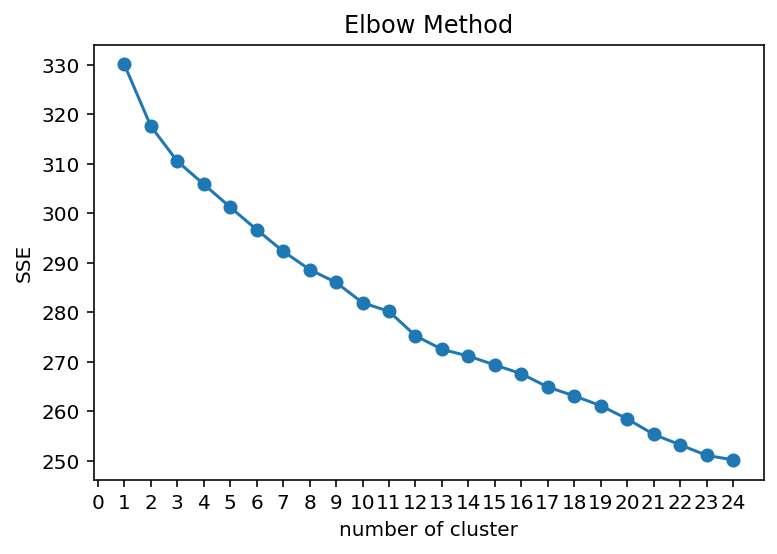

In [231]:
x = normalize(tfidf_matrix_okt)
# L2 정규화

def elbow(X):
  sse = []
  for i in range(1,25):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

  plt.plot(range(1,25), sse, marker='o')
  plt.xlabel('number of cluster')
  plt.xticks(np.arange(0,25,1))
  plt.ylabel('SSE')
  plt.title('Elbow Method')
  plt.show()
elbow(x)

In [232]:
clusters_num = 19
kmeans = KMeans(n_clusters = clusters_num).fit(x)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [233]:
df = pd.DataFrame(data=title_okt)
df.columns = ["title"]
df['num']=0
for i in range(len(df)):
  df.iloc[i, 1] = i

df['labels'] = labels
# 클러스터링 라벨 부여
df.head(3)

,title,num,labels
0,춘천 의암호 자전거 경찰관 뺑소니 트럭,0,9
1,탐정 클럽 간 죄 성폭력 피고인 왜 국민 참여 재판,1,0
2,날씨 대체로 맑음 내륙 대부분 도 웃돌,2,12


In [234]:
for i in range(clusters_num):
  print('<<Clustering Label {0}>>'.format(i)+'\n')
  print(df.loc[df['labels']==i])

<<Clustering Label 0>>

                             title  num  labels
1     탐정 클럽 간 죄 성폭력 피고인 왜 국민 참여 재판    1       0
3                               결혼    3       0
7    이성복 소주 한잔 가마솥 손 두부 텃밭 상추 대흥 밥    7       0
8                               부고    8       0
12                       안문훈 시조 풍경   12       0
..                             ...  ...     ...
326                          병원 소식  326       0
333                원주 유아 놀이 체험 학습장  333       0
335         포토 뉴스 총 도지 회 홍보물 제작 교육  335       0
336               강원 농협 상호금융 대출 달성  336       0
338        관찰 카메라 농업 꿈 수확 청년 농부 관찰  338       0

[115 rows x 3 columns]
<<Clustering Label 1>>

                                               title  num  labels
32                                    오늘 날씨 강원 지역 날씨   32       1
39                            오늘 날씨 전국 무더위 계속 낮 최고 도   39       1
67                                          오늘 날씨 오후   67       1
142                               오늘 날씨 전국 지역별 날씨 예보  142       1
144                   

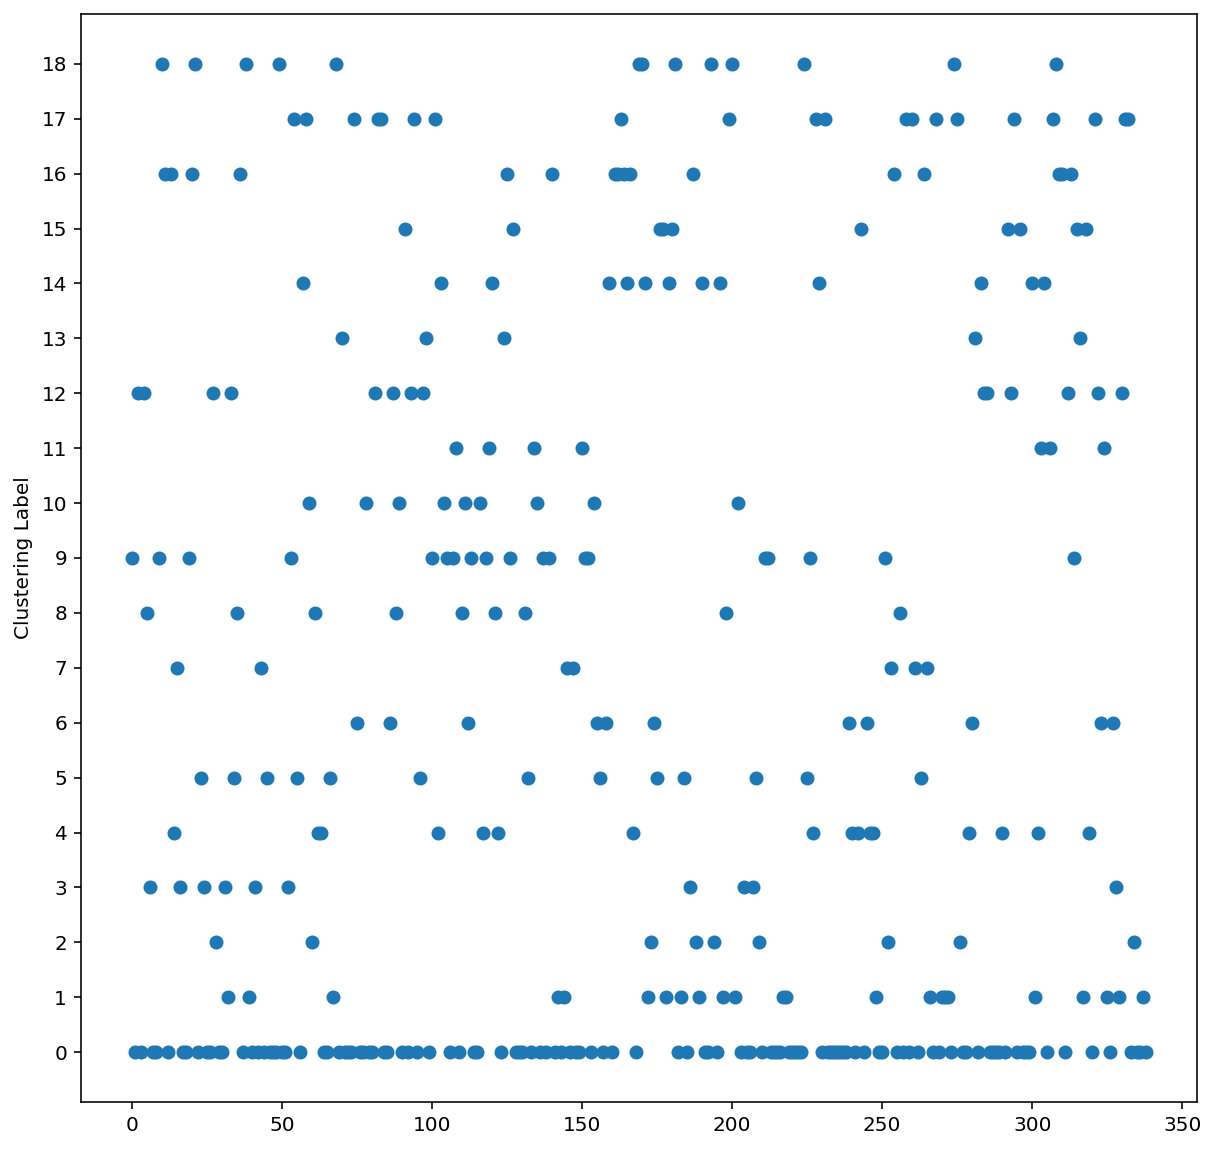

In [235]:
plt.figure(figsize=(10,10))
plt.scatter(x=df['num'],y=df['labels'])
plt.ylabel('Clustering Label')
plt.yticks(np.arange(0,int(clusters_num),1))
plt.show()

# Word cloud

In [251]:
title_all = ''.join(title_list)   # 전체를 한 문장으로 만듦
nouns = okt.nouns(title_all)
# 한 글자 단어 제거
for kwd in nouns:
  if len(kwd) < 2:
    del nouns[nouns.index(kwd)]
count = Counter(nouns)
noun_list = count.most_common(100)

words = dict(noun_list)

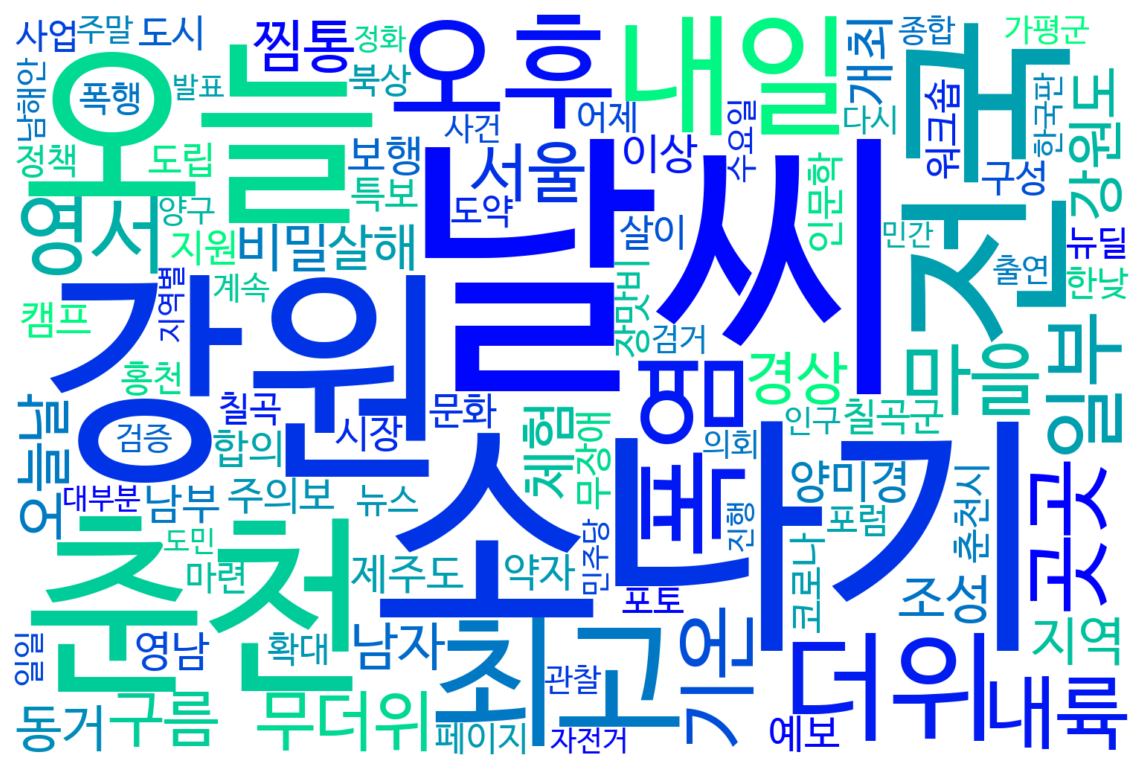

In [253]:
wordcloud = WordCloud(font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', background_color='white',colormap = "winter_r", width=1500, height=1000).generate_from_frequencies(words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
